# Data-driven prediction of energy use of appliances

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions
were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the
temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for
10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters.
Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded
from a public data set from Reliable Prognosis (rp5.ru) and merged together with the
experimental data sets using the date and time column. Two random variables have been
included in the data set for testing the regression models and to filter out non-predictive attributes
(parameters).

date time year-month-day hour:minute:second

Appliances, energy use in Wh (Dependent variable)

lights, energy use of light fixtures in the house in Wh (Drop this column)

T1, Temperature in kitchen area, in Celsius

RH1, Humidity in kitchen area, in % 

T2, Temperature in living room area, in Celsius 

RH2, Humidity in living room area, in %

T3, Temperature in laundry room area

RH3, Humidity in laundry room area, in % 

T4, Temperature in office room, in Celsius 

RH4, Humidity in office room, in %

T5, Temperature in bathroom, in Celsius

RH5, Humidity in bathroom, in % 

T6, Temperature outside the building (north side), in Celsius

RH6, Humidity outside the building (north side), in %

T7, Temperature in ironing room , in Celsius

RH7, Humidity in ironing room, in % 

T8, Temperature in teenager room 2, in Celsius 

RH8, Humidity in teenager room 2, in %

T9, Temperature in parents room, in Celsius

RH9, Humidity in parents room, in % 

To, Temperature outside (from Chievres weather station), in
Celsius Pressure (from Chievres weather station), in mm Hg 

RHout, Humidity outside (from
Chievres weather station), in %

Wind speed (from Chievres weather station), in m/s

Visibility (from Chievres weather station), in km

Tdewpoint (from Chievres weather station), Â°C

rv1, Random variable 1, nondimensional

rv2, Random variable 2, nondimensional

Where indicated, hourly data (then interpolated) from the nearest airport weather station
(Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis,
rp5.ru. Permission was obtained from Reliable Prognosis for the distribution of the 4.5 months of
weather data.

In [ ]:
pip install scikit-optimize  #for skopt and skopt.space

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Importing all the libarary
# Importing the libraries
import numpy as np
import pandas as pd
from numpy import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgbm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import time
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from skopt.space import Real, Categorical, Integer

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [ ]:
#Connect with Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_energy=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Almabetter/ML/project/data_application_energy.csv')

In [ ]:
#According to questions drop 'lights' column
df_energy=df_energy.drop('lights',axis=1)

In [ ]:
df=df_energy.copy()

In [ ]:
df

,date,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,...,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,...,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,...,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,...,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,60,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,...,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,...,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,...,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,...,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,45.790000,...,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784


In [ ]:
df.shape

(19735, 28)

We didn't have any null and duplicate value in our dataset

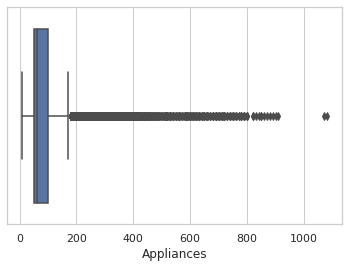

In [ ]:
# Find outliers

# boxplot appliances
sns.set(style="whitegrid")
ax = sns.boxplot(df.Appliances)

In [ ]:
# Removing the outliers
def removeOutliers(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
 
    print("IQR value for column %s is: %s" % (col, IQR))
    global outlier_free_list
    global filtered_data
 
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    outlier_free_list = [x for x in data[col] if (
        (x > lower_range) & (x < upper_range))]
    filtered_data = data.loc[data[col].isin(outlier_free_list)]
 
 


In [ ]:
for i in df.columns:
      if i == df.columns[1]:
        removeOutliers(df, i) 
# Assigning filtered data back to our original variable
df = filtered_data
print("Shape of data after outlier removal is: ", df.shape)

IQR value for column Appliances is: 50.0
Shape of data after outlier removal is:  (17597, 28)


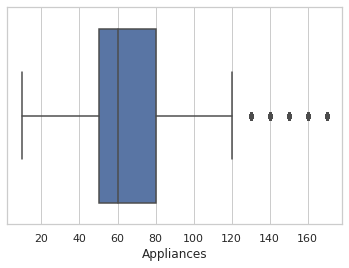

In [ ]:
sns.set(style="whitegrid")
ax = sns.boxplot(df.Appliances)

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# df['month'] = df.date.dt.month       #not much related
# df['weekday'] = df.date.dt.weekday   #not much related
# df['hour'] = df.date.dt.hour         #not much related
# df['week'] = df.date.dt.week         #not much related

# Feature Engineering

In [ ]:
# Dropping 'date' column
df.drop(columns=['date'], inplace=True)

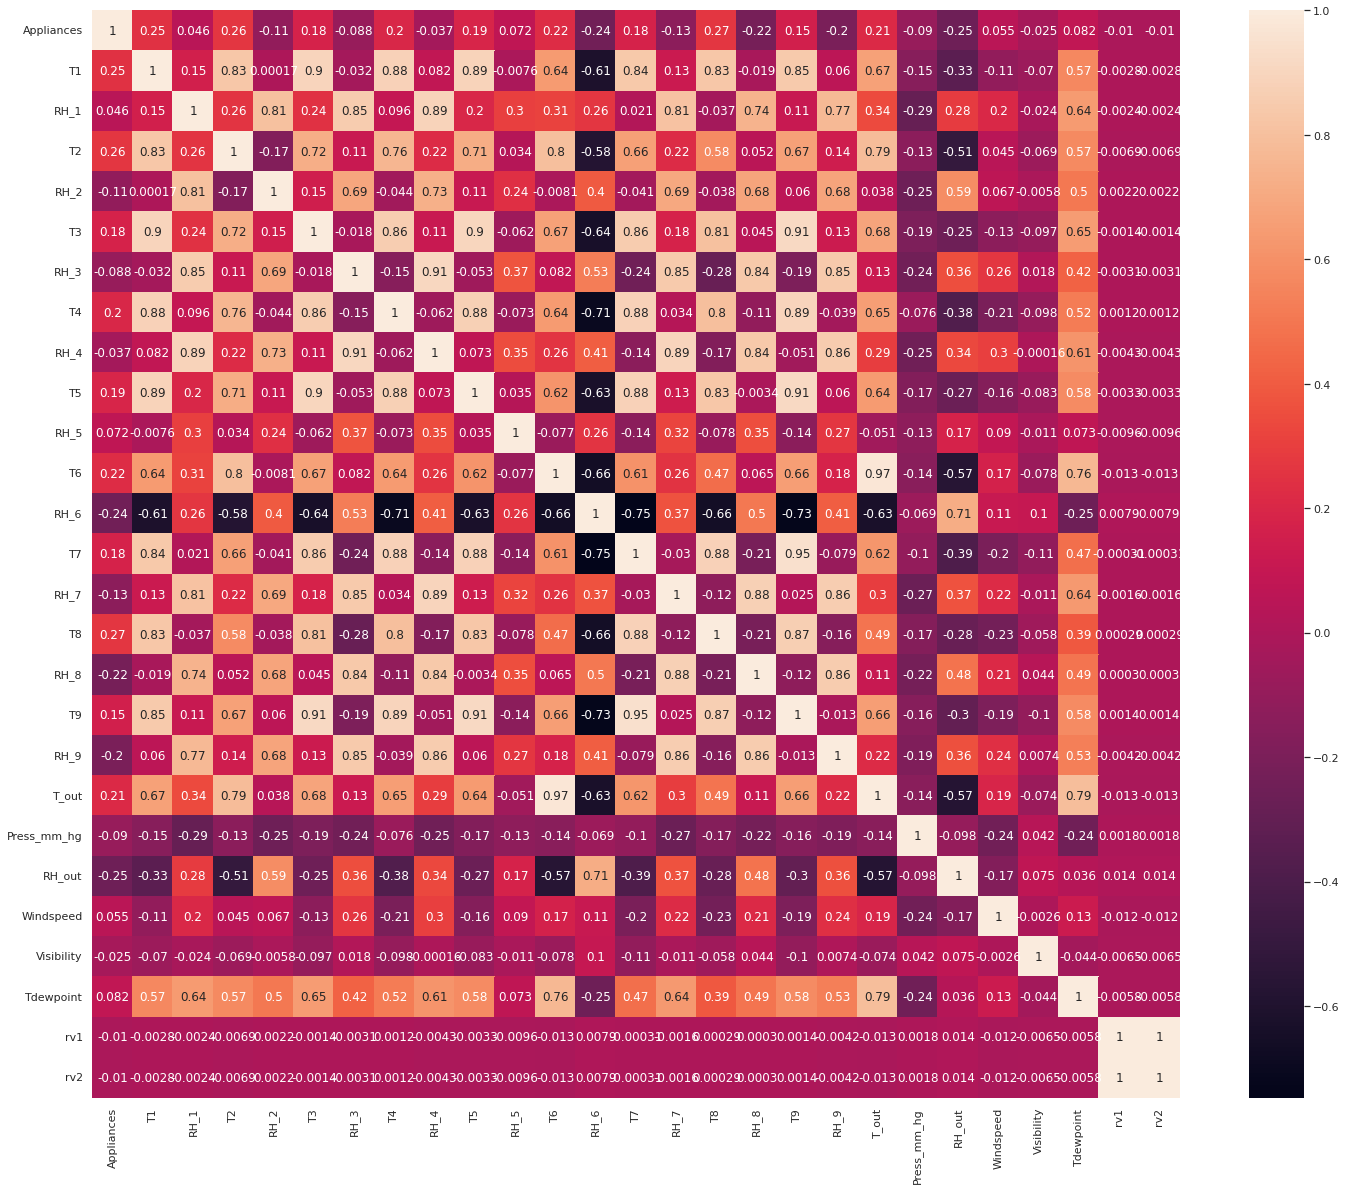

In [ ]:
fig = plt.figure(figsize=(25,20))
sns.heatmap(df.corr(), annot=True, square=True);


# Observations based on correlation plot:-
1. Temperature - All the temperature variables from T1-T9 and T_out have positive correlation with the target Appliances . 

2. For the indoor temperatures, the correlations are high as expected, since the ventilation is driven by the HRV unit and minimizes air temperature differences between rooms. 

3. Five columns have a high degree of correlation with T9 - T3,T4,T5,T7,T8 also T6 & T_Out has high correlation(both temperatures from outside) . Hence T6 and T9 can be removed from training set as information provided by them can be provided by other fields.

4. Weather attributes - Visibility, Tdewpoint, Press_mm_hg have low correlation values

5. Humidity - RH_3 & RH_4 has high correlation(both temperatures from outside) . Hence RH_3 or RH_4 can be removed from training set as information provided by them can be provided by other fields.
There are no significantly high correlation cases (> 0.9) for humidity sensors.

6. Random variables have no role to play

In [ ]:
df.drop(columns=['rv1','rv2','T6','T9','Visibility','RH_4'], inplace=True)

In [ ]:
# df.drop(columns=['Tdewpoint','Press_mm_hg'], inplace=True)

In [ ]:
app=df[['Appliances']]


In [ ]:
df=df.drop('Appliances',axis=1)


In [ ]:
#assigning variable
X=df
y=app

Preparation for model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 40)

SelectKbest and f_regression

In [ ]:
# #make function for top 10 features
def select_features(X_train, y_train, X_test):
  # configure to select all features
  fs = SelectKBest(score_func=f_regression, k='all')         # or k=14,18,20
  # learn relationship from training data
  fs.fit(X_train, y_train)
  # transform train input data
  X_train_fs = fs.transform(X_train)
  # transform test input data
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs, fs

In [ ]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

In [ ]:
X_train=X_train_fs
X_test=X_test_fs
y_train=y_train

In [ ]:
# Scale the data
scaler = StandardScaler() 
X_train_sc=scaler.fit_transform(X_train)
X_test_sc=scaler.transform(X_test)


Making MOdels

In [ ]:
models = [
           ['LinearRegression: ', LinearRegression()],
           ['Lasso: ', Lasso()],
           ['Ridge: ', Ridge()],
           ['DecisionTreeRegresson: ', DecisionTreeRegressor()],
           ['RandomForest ',RandomForestRegressor()],
           ['GradientBoostingRegression: ', GradientBoostingRegressor()] ,
           ['XGBRegressor: ', xgb.XGBRegressor()],
           ['AdaBoostRegressor: ',AdaBoostRegressor()],
           ['LgbmRegressor: ',lgbm.LGBMRegressor()]
         ]

In [ ]:
model_data = []
for name,curr_model in models :
    curr_model_data = {}
    curr_model.random_state = 78
    curr_model_data["Name"] = name
    start = time.time()
    curr_model.fit(X_train_sc,y_train)
    end = time.time()
    curr_model_data["Train_Time"] = end - start
    curr_model_data["Train_R2_Score"] = metrics.r2_score(y_train,curr_model.predict(X_train_sc))
    curr_model_data["Test_R2_Score"] = metrics.r2_score(y_test,curr_model.predict(X_test_sc))
    # curr_model_data["Test_MSE_Score"] = mean_squared_error(y_test_sc,curr_model.predict(X_test_sc))
    curr_model_data["Test_RMSE_Score"] = sqrt(mean_squared_error(y_test,curr_model.predict(X_test_sc)))
    model_data.append(curr_model_data)


[18:06:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
model_data

[{'Name': 'LinearRegression: ',
  'Test_R2_Score': 0.31476581810834814,
  'Test_RMSE_Score': 23.811254557864245,
  'Train_R2_Score': 0.30250014813082327,
  'Train_Time': 0.020263671875},
 {'Name': 'Lasso: ',
  'Test_R2_Score': 0.25273596219714467,
  'Test_RMSE_Score': 24.86564961119366,
  'Train_R2_Score': 0.24224451232565192,
  'Train_Time': 0.03141474723815918},
 {'Name': 'Ridge: ',
  'Test_R2_Score': 0.31473897013924745,
  'Test_RMSE_Score': 23.81172102435244,
  'Train_R2_Score': 0.3024997669310624,
  'Train_Time': 0.009408235549926758},
 {'Name': 'DecisionTreeRegresson: ',
  'Test_R2_Score': 0.4306639152829236,
  'Test_RMSE_Score': 21.70436696737653,
  'Train_R2_Score': 1.0,
  'Train_Time': 0.4537198543548584},
 {'Name': 'RandomForest ',
  'Test_R2_Score': 0.6897592739249752,
  'Test_RMSE_Score': 16.021831962413604,
  'Train_R2_Score': 0.958174700786924,
  'Train_Time': 34.72391366958618},
 {'Name': 'GradientBoostingRegression: ',
  'Test_R2_Score': 0.42425543300631763,
  'Test_RMS

In [ ]:
result=pd.DataFrame(model_data)
result

,Name,Train_Time,Train_R2_Score,Test_R2_Score,Test_RMSE_Score
0,LinearRegression:,0.020264,0.302500,0.314766,23.811255
1,Lasso:,0.031415,0.242245,0.252736,24.865650
2,Ridge:,0.009408,0.302500,0.314739,23.811721
3,DecisionTreeRegresson:,0.453720,1.000000,0.430664,21.704367
4,RandomForest,34.723914,0.958175,0.689759,16.021832
5,GradientBoostingRegression:,6.352446,0.470723,0.424255,21.826178
6,XGBRegressor:,1.310240,0.464242,0.417175,21.959985
7,AdaBoostRegressor:,1.611339,-0.046391,-0.022408,29.085391
8,LgbmRegressor:,0.617270,0.712971,0.601475,18.158934


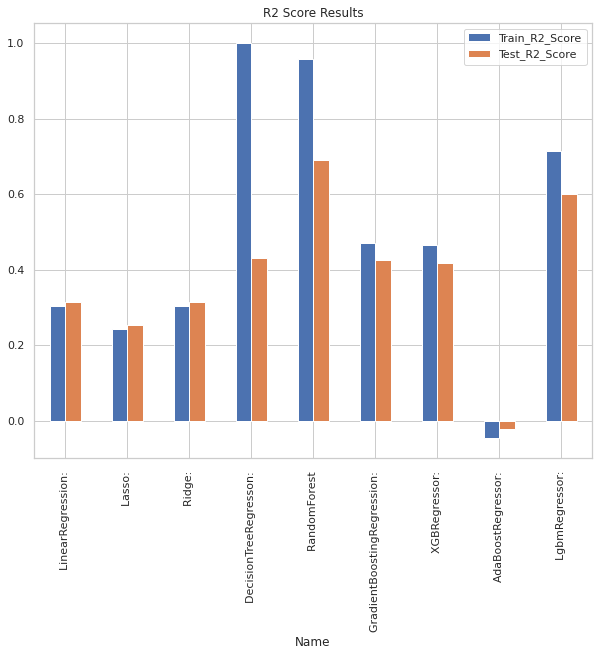

In [ ]:
result.plot(x="Name", y=['Train_R2_Score' , 'Test_R2_Score'], kind="bar" , title = 'R2 Score Results' , figsize= (10,8)) 

Hyper Tuning for Random Forest via Bayes-search

In [ ]:
reg = RandomForestRegressor(random_state=0)
# Instantiate the bayes search model
bayes_search = BayesSearchCV(estimator=reg,
                       search_spaces = {
                          'max_depth': Integer(10,11),
                          'min_samples_leaf': Integer(3,4),
                          'min_samples_split': Integer(5,10),
                          'n_estimators': Integer(90,100),
                          'max_features': ["auto", "sqrt", "log2"]
                        },
                       cv = 5, verbose=2, scoring='r2')

bayes_search.fit(X_train_sc, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=94; total time=   2.4s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=94; total time=   2.3s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=94; total time=   2.3s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=94; total time=   2.3s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=94; total time=   2.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=98; total time=   2.3s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=98; total time=   2.3s
[CV] END max_depth=10, max_features=log2, min_s

BayesSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
              scoring='r2',
              search_spaces={'max_depth': Integer(low=10, high=11, prior='uniform', transform='normalize'),
                             'max_features': ['auto', 'sqrt', 'log2'],
                             'min_samples_leaf': Integer(low=3.5, high=4.5, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=5, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=90, high=100, prior='uniform', transform='normalize')},
              verbose=2)

In [ ]:
bayes_search.best_params_

OrderedDict([('max_depth', 11),
             ('max_features', 'auto'),
             ('min_samples_leaf', 4),
             ('min_samples_split', 7),
             ('n_estimators', 96)])

In [ ]:
# R2 score on training set with tuned parameters

bayes_search.best_estimator_.score(X_train_sc,y_train)

0.7315842028279134

In [ ]:
# R2 score on test set with tuned parameters
bayes_search.best_estimator_.score(X_test_sc,y_test)


0.6037010700692271

Not giving good Results 